In [2]:
# 전처리
import pickle
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

def load_cifar_batch(filename):
    with open(filename, 'rb') as file:
        batch = pickle.load(file, encoding='latin1')
    # 이미지 데이터 재배열: [num_samples, 3, 32, 32]
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
    return features, labels

def create_datasets(data_paths, test_path):
    # 데이터를 로드하고 하나의 큰 훈련 데이터셋으로 결합
    train_features = []
    train_labels = []
    for path in data_paths:
        features, labels = load_cifar_batch(path)
        train_features.append(features)
        train_labels.append(labels)
    train_features = np.concatenate(train_features)
    train_labels = np.concatenate(train_labels)
    
    # 테스트 데이터 로드
    test_features, test_labels = load_cifar_batch(test_path)

    # numpy 배열을 PyTorch 텐서로 변환
    train_features = torch.tensor(train_features).permute(0, 3, 1, 2).float() / 255.0
    train_labels = torch.tensor(train_labels).long()
    test_features = torch.tensor(test_features).permute(0, 3, 1, 2).float() / 255.0
    test_labels = torch.tensor(test_labels).long()
    
    # TensorDataset 생성
    train_dataset = TensorDataset(train_features, train_labels)
    test_dataset = TensorDataset(test_features, test_labels)
    return train_dataset, test_dataset

# 파일 경로 설정
data_paths = [f'cifar-10-batches-py/data_batch_{i}' for i in range(1, 6)]
test_path = 'cifar-10-batches-py/test_batch'

# 데이터셋 생성
train_dataset, test_dataset = create_datasets(data_paths, test_path)

# DataLoader 생성 예
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [2]:
# 학습
import torch
from torch import nn, optim

In [3]:
from model import ModelClass

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ModelClass()
model.to(device)

criteration = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

epochs = 10
# 학습 로직
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criteration(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader)}")

    # 성능 테스트
    model.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == targets).sum().item()
            total += targets.size(0)
    accuracy = 100 * total_correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

/home/swjeong/swjeong/swjenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/swjeong/swjeong/swjenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/swjeong/swjeong/swjenv/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_

Epoch 0, Loss: 1.4303537471520016
Test Accuracy: 59.51%
Epoch 1, Loss: 0.8351202780557105
Test Accuracy: 69.48%
Epoch 2, Loss: 0.6135322963413985
Test Accuracy: 77.36%
Epoch 3, Loss: 0.4773394625319544
Test Accuracy: 79.37%
Epoch 4, Loss: 0.3824448018046596
Test Accuracy: 78.43%
Epoch 5, Loss: 0.31271432585957104
Test Accuracy: 80.39%
Epoch 6, Loss: 0.24858952629025025
Test Accuracy: 80.82%
Epoch 7, Loss: 0.2060038364442337
Test Accuracy: 81.37%
Epoch 8, Loss: 0.16349902953666723
Test Accuracy: 81.06%
Epoch 9, Loss: 0.13853420683270906
Test Accuracy: 80.36%


In [4]:
torch.save(model.state_dict(), 'torch.pt')

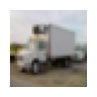

Real Label: truck      Predicted Label: truck     


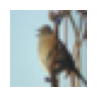

Real Label: bird       Predicted Label: bird      


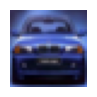

Real Label: automobile Predicted Label: automobile


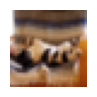

Real Label: cat        Predicted Label: dog       


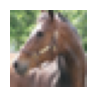

Real Label: horse      Predicted Label: horse     


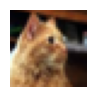

Real Label: cat        Predicted Label: horse     


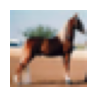

Real Label: horse      Predicted Label: horse     


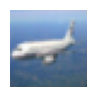

Real Label: airplane   Predicted Label: airplane  


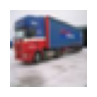

Real Label: truck      Predicted Label: truck     


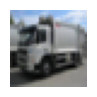

Real Label: truck      Predicted Label: truck     


In [11]:
# 추론
import random
import matplotlib.pyplot as plt

import torch
from model import ModelClass

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ModelClass()
model.load_state_dict(torch.load('torch.pt'))
model.to(device)

# test 데이터셋에서 10개의 샘플을 무작위로 선택
random.seed(42)
samples = random.sample(range(len(test_dataset)), k=10)

def convert_label(label):
    class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    return class_labels[label]

# 선택된 샘플에 대해 라벨 출력 및 모델 추론
for sample in samples:
    data, target = test_dataset[sample]
    real_label = convert_label(target.item())
    data = data.to(device)
    model.eval()
    with torch.no_grad():
        output = model(data.unsqueeze(0))
        _, predicted = torch.max(output, 1)
    predicted_label = convert_label(predicted.item())

    data_cpu = data.cpu().detach()

    plt.figure(figsize=(3, 1))
    plt.imshow(data_cpu.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    
    print(f"Real Label: {real_label:10} Predicted Label: {predicted_label:10}")

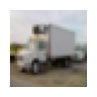

Real Label: truck      Predicted Label: automobile


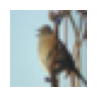

Real Label: bird       Predicted Label: automobile


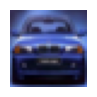

Real Label: automobile Predicted Label: automobile


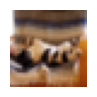

Real Label: cat        Predicted Label: automobile


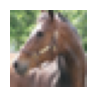

Real Label: horse      Predicted Label: automobile


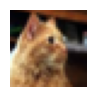

Real Label: cat        Predicted Label: automobile


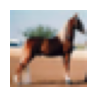

Real Label: horse      Predicted Label: automobile


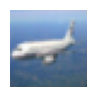

Real Label: airplane   Predicted Label: automobile


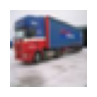

Real Label: truck      Predicted Label: automobile


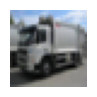

Real Label: truck      Predicted Label: automobile


In [12]:
# 학습이 이루어지지 않은 모델 추론
model = ModelClass().to(device)

for sample in samples:
    data, target = test_dataset[sample]
    real_label = convert_label(target.item())
    data = data.to(device)
    model.eval()
    with torch.no_grad():
        output = model(data.unsqueeze(0))
        _, predicted = torch.max(output, 1)
    predicted_label = convert_label(predicted.item())

    data_cpu = data.cpu().detach()

    plt.figure(figsize=(3, 1))
    plt.imshow(data_cpu.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    
    print(f"Real Label: {real_label:10} Predicted Label: {predicted_label:10}")